In [10]:
import keras
keras.__version__

'2.8.0'


- We extracted a timeseries of data points including opening price, high price, low price, trading volume, and closing price. 

- We would use historical closing price to predict what the closing price will be one trading day after the last data point collected. 

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import pandas as pd

data_dir = "/content/drive/MyDrive/DeepL_27_Final Project/"
fname = os.path.join(data_dir, 'AAPL_20120601.csv')#ten years data

df=pd.read_csv(fname)
df_close=df.loc[:,("Date","Close")]
df_close

,Date,Close
0,2012-06-01,20.035357
1,2012-06-04,20.153214
2,2012-06-05,20.101070
3,2012-06-06,20.409286
4,2012-06-07,20.418571
...,...,...
2490,2022-04-25,162.880005
2491,2022-04-26,156.800003
2492,2022-04-27,156.570007
2493,2022-04-28,163.639999


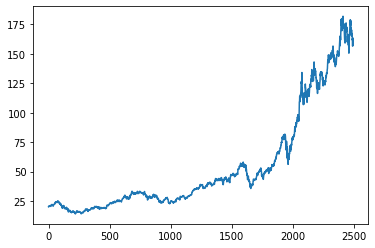

In [13]:
# Let's convert all of these 2495 lines of data into a Numpy array
import numpy as np

float_data=df_close.loc[:,"Close"].to_numpy()
float_data=float_data.reshape(float_data.shape[0],-1) ##1D array to 2D array of one column
float_data

# The plot of closing price over time
from matplotlib import pyplot as plt

plt.plot(range(len(float_data)), float_data)
plt.show()

- Looking at the data over a scale of days, the stock price looks a lot more chaotic. Next, we would like to find out if this timeseries predictable at a daily scale.

## Preparing the data


The exact formulation of our problem will be the following: **given data going as far back as *lookback* timesteps** (a timestep is 1 trading day) 
and **sampled every *steps* timesteps**, can we **predict the closing stock price in *delay* timesteps**?

We will use the following parameter values:

* lookback = 14, our observations will go back 14 days.
* steps = 1, our observations will be sampled at one data point per 1 trading day.
* delay = 1, our targets will be 1 trading day in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: **the data is already numerical, so we don't need to do any 
vectorization**. All we need to do is to **standardize the data** so that the neural network could read the input better. 
* Write a **Python generator** that takes our current array of float data and yields batches of data from the recent past, **alongside with a 
target closing stock price in the future**. We will generate the samples on the fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
**1,400** timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [14]:
mean = float_data[:1400].mean(axis=0)
float_data -= mean
std = float_data[:1400].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple *(samples, targets)* where *samples* is one batch of input data and 
*targets* is the corresponding array of target temperatures. It takes the following arguments:

* *data*: The original array of floating point data, which we just standardized in the code snippet above.
* *lookback*: How many timesteps back should our input data go.
* *delay*: How many timesteps in the future should our target be.
* *min_index* and *max_index*: Indices in the *data* array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* *shuffle*: Whether to shuffle our samples or draw them in chronological order.
* *batch_size*: The number of samples per batch.
* *step*: The period, in timesteps, at which we sample data. We will set it 1 in order to draw one data point every trading day.

In [15]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0] # Hard-coded in the original code, change to 0 instead of 1
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different segments of the original data: the training generator looks at the first **1,400** timesteps, the 
validation generator looks at the following **800**, and the test generator looks at the remainder.

In [16]:
lookback = 14
step = 1
delay = 1
batch_size = 64

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1400,#1400 for training
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=1401,
                    max_index=2100,#800 for validation
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=2101,
                     max_index=None,#395 for testing
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (2100 - 1401 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 2101 - lookback) // batch_size

## A common sense, non-machine learning baseline


- Before we start leveraging black-box deep learning models to solve our stock prediction problem, let's try out a simple common-sense approach. 

- It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for which there is no known solution (yet). 

- In our case, the stock price timeseries can safely be assumed to be continuous (the stock price tomorrow are likely to be close to the stock price of today). Thus a common sense naive approach would be to always predict that the stock price tomorrow will be equal to the stock price today. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 

Mean Absolute Error is simply equal to:
np.mean(np.abs(preds - targets))

0.16347576259156615


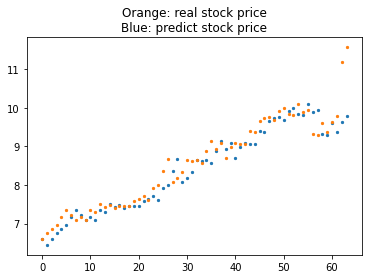

In [17]:
#evaluation loop
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 0]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return preds,targets

# Let's plot the most recent validation batch
preds,targets = evaluate_naive_method()
plt.scatter(range(len(preds)),preds,s=5)
plt.scatter(range(len(targets)),targets,s=5)
plt.title("Orange: real stock price\nBlue: predict stock price")
plt.show()

It yields a MAE of **0.163**. Since our stock price data has been standardized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable.  

## A Basic Deep Learning Approach

- Establish a common sense baseline without deep learning approaches such as RNNs (try simple and cheap deep learning models, such as small densely-connected networks).

- This is the best way to make sure that any further complexity we throw at the problem later on is legitimate and delivers real benefits.

- Here is a simply fully-connected model in which we start by flattening the data, then run it through two *Dense* layers. **Note the lack of 
activation function on the last *Dense* layer, which is typical for a regression problem.** **We use MAE as the loss.** Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

- The approach consisted in first flattening the timeseries, which removed the notion of time from the input data.

In [18]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=32, 
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=2)
# loss: 0.0685 - val_loss: 0.1695

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


32/32 - 3s - loss: 0.1319 - val_loss: 0.3386 - 3s/epoch - 93ms/step
Epoch 2/50
32/32 - 0s - loss: 0.0973 - val_loss: 0.3669 - 161ms/epoch - 5ms/step
Epoch 3/50
32/32 - 0s - loss: 0.0884 - val_loss: 0.2349 - 124ms/epoch - 4ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0853 - val_loss: 0.2632 - 160ms/epoch - 5ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0838 - val_loss: 0.1834 - 136ms/epoch - 4ms/step
Epoch 6/50
32/32 - 0s - loss: 0.0799 - val_loss: 0.5442 - 143ms/epoch - 4ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0783 - val_loss: 0.3204 - 163ms/epoch - 5ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0816 - val_loss: 0.2074 - 161ms/epoch - 5ms/step
Epoch 9/50
32/32 - 0s - loss: 0.0804 - val_loss: 0.1946 - 163ms/epoch - 5ms/step
Epoch 10/50
32/32 - 0s - loss: 0.0755 - val_loss: 0.4262 - 137ms/epoch - 4ms/step
Epoch 11/50
32/32 - 0s - loss: 0.0771 - val_loss: 0.1745 - 144ms/epoch - 4ms/step
Epoch 12/50
32/32 - 0s - loss: 0.0781 - val_loss: 0.1701 - 126ms/epoch - 4ms/step
Epoch 13/50
32/32 - 0s - loss: 0.0762 

In [19]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 14)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               1920      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


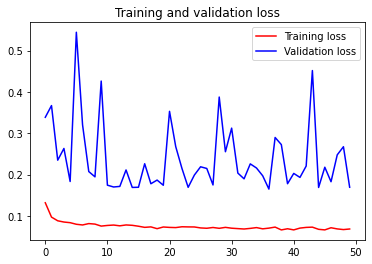

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


- Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

- You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## Model 1: one recurrent layer baseline 
- Our first approach didn't do so well with a fluctuated validation loss. Now, let us instead look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

- Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. It is a generally a good idea to **increase the capacity of the network** until overfitting becomes our primary obstacle (assuming that we are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

- To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True:

In [21]:
#one recurrent layer baseline
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=64,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=1)
# loss: 0.0584 - val_loss: 0.4062

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


64/64 [==============================] - 8s 25ms/step - loss: 0.1415 - val_loss: 0.9964
Epoch 2/50
64/64 [==============================] - 1s 10ms/step - loss: 0.0996 - val_loss: 0.8248
Epoch 3/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0909 - val_loss: 1.0881
Epoch 4/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0820 - val_loss: 0.7314
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0773 - val_loss: 0.6550
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0724 - val_loss: 0.6267
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0696 - val_loss: 0.5439
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0674 - val_loss: 0.6145
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0652 - val_loss: 0.6296
Epoch 10/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0666 - val_loss: 0.5477
Epoch 11/50
64/64 [========

In [22]:
model = Sequential()
model.add(layers.LSTM(128, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


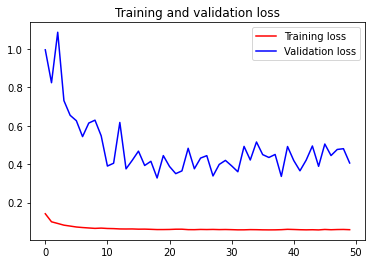

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We are able to approach to baseline closely, but not strictly beating the baseline model. 

Our new validation MAE of **~0.4062**(before we start overfitting) translates to a mean absolute error, which is not much lower than the previous one.

## Model 2: stacking recurrent layers

In [24]:
#stacking recurrent layers
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                    #  dropout=0.1,
                    #  recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.1))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=32,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# loss: 0.0670 - val_loss: 0.2006

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


32/32 [==============================] - 8s 132ms/step - loss: 0.2151 - val_loss: 1.1420
Epoch 2/50
32/32 [==============================] - 2s 69ms/step - loss: 0.1525 - val_loss: 0.6834
Epoch 3/50
32/32 [==============================] - 2s 69ms/step - loss: 0.1344 - val_loss: 0.7679
Epoch 4/50
32/32 [==============================] - 2s 68ms/step - loss: 0.1226 - val_loss: 0.7640
Epoch 5/50
32/32 [==============================] - 2s 67ms/step - loss: 0.1176 - val_loss: 0.8525
Epoch 6/50
32/32 [==============================] - 2s 67ms/step - loss: 0.1112 - val_loss: 1.3768
Epoch 7/50
32/32 [==============================] - 2s 68ms/step - loss: 0.1082 - val_loss: 0.8860
Epoch 8/50
32/32 [==============================] - 2s 67ms/step - loss: 0.1030 - val_loss: 1.0805
Epoch 9/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0973 - val_loss: 0.6523
Epoch 10/50
32/32 [==============================] - 2s 69ms/step - loss: 0.0957 - val_loss: 0.9620
Epoch 11/50
32/32 [

In [25]:
model = Sequential()
model.add(layers.LSTM(128,
                    #  dropout=0.1,
                    #  recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.1))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 128)         66560     
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


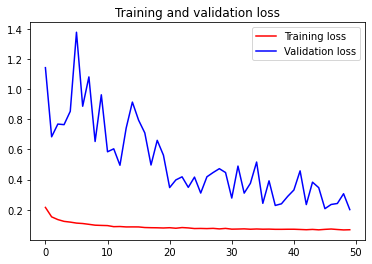

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 3: bidirectional RNNs

A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our stock price forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [39]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0] # Hard-coded in the original code, change to 0 instead of 1
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=1400,#
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=1401,#
    max_index=2100,#
    step=step,
    batch_size=batch_size)

In [48]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.LSTM(128), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=32,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
#loss: 0.0631 - val_loss: 0.3456

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


32/32 [==============================] - 5s 30ms/step - loss: 0.1864 - val_loss: 1.3825
Epoch 2/40
32/32 [==============================] - 0s 9ms/step - loss: 0.1232 - val_loss: 1.2394
Epoch 3/40
32/32 [==============================] - 0s 9ms/step - loss: 0.1165 - val_loss: 1.1177
Epoch 4/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1053 - val_loss: 0.8439
Epoch 5/40
32/32 [==============================] - 0s 9ms/step - loss: 0.1004 - val_loss: 0.8251
Epoch 6/40
32/32 [==============================] - 0s 9ms/step - loss: 0.0945 - val_loss: 0.6361
Epoch 7/40
32/32 [==============================] - 0s 9ms/step - loss: 0.0890 - val_loss: 0.6406
Epoch 8/40
32/32 [==============================] - 0s 9ms/step - loss: 0.0876 - val_loss: 0.6567
Epoch 9/40
32/32 [==============================] - 0s 9ms/step - loss: 0.0805 - val_loss: 0.6139
Epoch 10/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0801 - val_loss: 0.6169
Epoch 11/40
32/32 [==========

In [50]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.LSTM(128), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 256)              133120    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


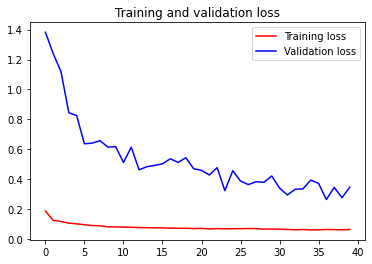

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Further Adjustment
* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely suboptimal.
* Use a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger Dense layer or even a stack of Dense layers.


# Utilize the best model (lowest validation MAE) to compare the predicted stock price and actual stock price on the test dataset

In [ ]:
#our chosen best model
model = Sequential()
model.add(layers.LSTM(128,
                    #  dropout=0.1,
                    #  recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.1))
model.add(layers.Dense(1))
model.summary()

In [ ]:
train_predict = model.predict(train_gen)
test_predict = model.predict(test_gen)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [1]:
plt.plot(test_predict, color = 'black', label = 'AAPL Stock Price')
plt.plot(train_predict, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()